In [1]:
from eleanor.source import Source
from eleanor.targetdata import TargetData
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
import photutils
from astropy.stats import SigmaClip
from lightkurve.lightcurve import LightCurve as LC
#%matplotlib notebook
%matplotlib inline

In [2]:
ra  = Angle(68.959732, u.deg)
dec = Angle(-64.02704, u.deg)
star = Source(coords=SkyCoord(ra, dec), sector=1)
data = TargetData(star)

/Users/AdinaFeinstein/Documents/ELLIE/eleanor/targetdata.py:281: UserWarning: Using scope = "postcard" sets the attribute self.flux_bkg_post rather than self.flux_bkg
  warnings.warn('Using scope = "postcard" sets the attribute self.flux_bkg_post rather than self.flux_bkg')


[0.00180906034193978, 0.002078222447763223, 0.0017705730962333853, 0.0018305946874134108, 0.00180906034193978, 0.002078222447763223, 0.002014291139836706, 0.0017668956689343728, 0.002486877802677454, 0.00180906034193978, 0.0024486794570628473, 0.0017813501782531515, 0.0027913406016060916, 0.00180906034193978, 0.0029696397029054487, 0.00180906034193978, 0.0034522133890852414, 0.00180906034193978, 0.0036297104854124697, 0.002000200147280198] [0.00180906034193978, 0.002078222447763223, 0.0017705730962333853, 0.0018305946874134108, 0.00180906034193978, 0.002078222447763223, 0.002014291139836706, 0.0017668956689343728, 0.002486877802677454, 0.00180906034193978, 0.0024486794570628473, 0.0017813501782531515, 0.0027913406016060916, 0.00180906034193978, 0.0029696397029054487, 0.00180906034193978, 0.0034522133890852414, 0.00180906034193978, 0.0036297104854124697, 0.002000200147280198]


In [11]:
q = data.quality == 0

A = np.load('/Users/AdinaFeinstein/Downloads/a_matrix.npy')

def science(flux):
    f = flux
    ATA = np.dot(A.T, A)
    invATA  = np.linalg.inv(ATA)
    A_coeff = np.dot(invATA, A.T)
    weights = np.dot(A_coeff, f) ## same as xhat
    return weights

<IPython.core.display.Javascript object>


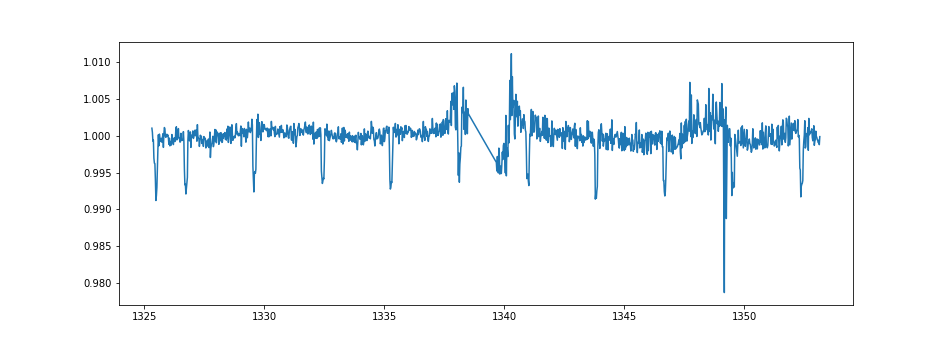

In [28]:
%matplotlib notebook
s_flux = data.corr_flux - np.dot(A, science(data.corr_flux))
plt.plot(data.time[q], s_flux[q]/np.nanmedian(s_flux[q]))

10.307


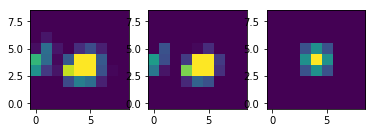

In [21]:
print(star.tess_mag)
plt.imshow(data.post_obj.flux[:,:,0], origin='lower', vmin=100, vmax=1000)
plt.close()
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
ax1.imshow(data.tpf[0], origin='lower', vmin=200, vmax=1000)
ax2.imshow(data.tpf[0]-data.flux_bkg[0], origin='lower', vmin=200, vmax=1000)
ax3.imshow(data.aperture, origin='lower')

In [5]:
def background(time, flux):
    bkg = []
    sigma_clip = SigmaClip(sigma=2.5)
    b = photutils.MMMBackground(sigma_clip=sigma_clip)
    for i in range(len(time)):
        bkg_value = b.calc_background(flux[i])
        bkg.append(bkg_value)
    return np.array(bkg)

In [14]:
%matplotlib notebook

bkg_tpf  = background(data.time, data.tpf)

postcard_flux = np.swapaxes(data.post_obj.flux, 0, 2)
bkg_post = background(data.post_obj.time, postcard_flux)

In [15]:
flux = []
for i in range(len(data.time)):
    f = np.sum((data.tpf[i]-bkg_tpf[i])*data.all_apertures[5])
    flux.append(f)
flux = np.array(flux)

<IPython.core.display.Javascript object>


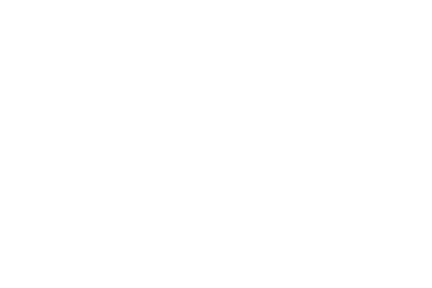

<IPython.core.display.Javascript object>


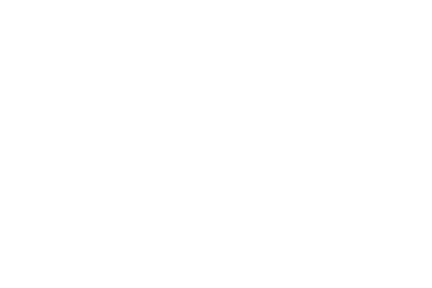

In [16]:
%matplotlib notebook 

q = data.quality == 0

plt.plot(data.time[q], data.raw_flux[q]/np.nanmedian(data.raw_flux[q])+0.03, 'k', label='Raw')
#plt.plot(data.time[q], flux[q], 'y')
#plt.plot(data.time[q][0:500], flux[q][0:500], 'k')
plt.plot(data.time[q], data.corr_flux[q]/np.nanmedian(data.corr_flux[q]), 'r', label='Corrected')
plt.legend()
#plt.plot(data.time[q], np.sum(data.tpf, axis=(1,2))[q], '.')

In [87]:
lc_obj = LC(time=data.time, flux=data.corr_flux)
print(lc_obj_og.estimate_cdpp(transit_duration=2))

3957.466275333055


In [90]:
flat_lc = lc_obj.flatten(polyorder=0)
flat_lc2 = lc_obj.flatten(polyorder=1)
flat_lc3 = lc_obj.flatten(polyorder=2, window_length=201)

3957.466275333055


<Figure size 1152x360 with 0 Axes>

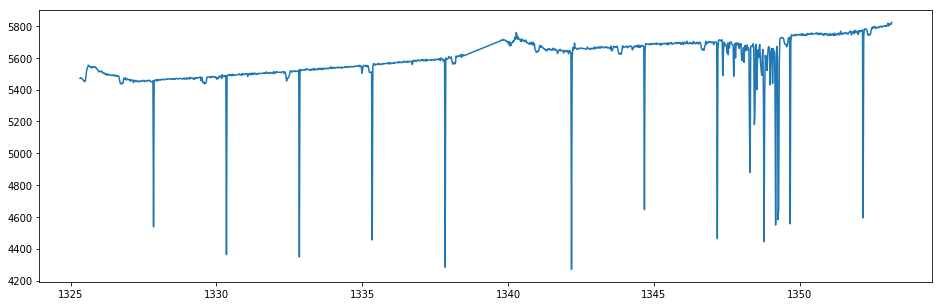

2808.089472855186


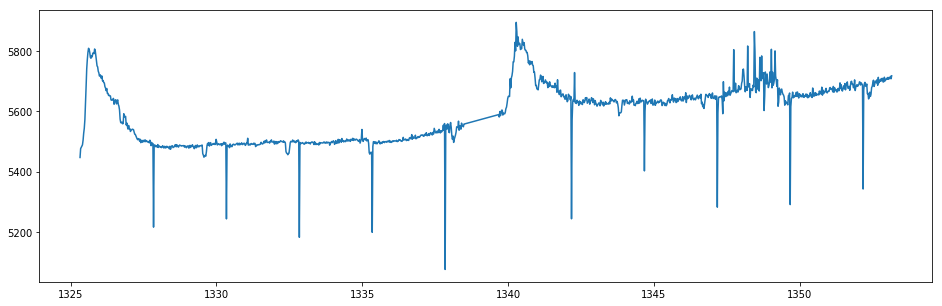

2747.164420169596


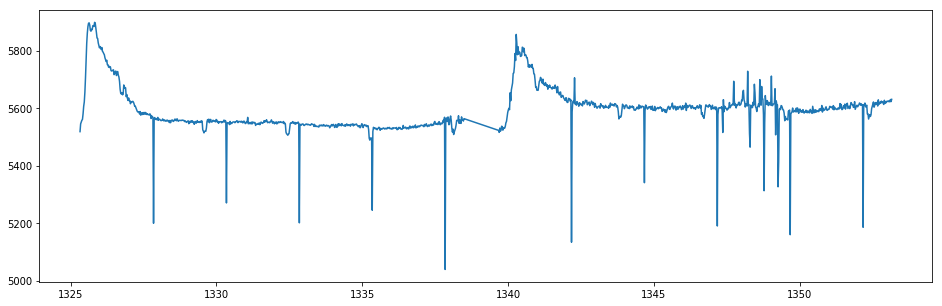

2027.3158778520528


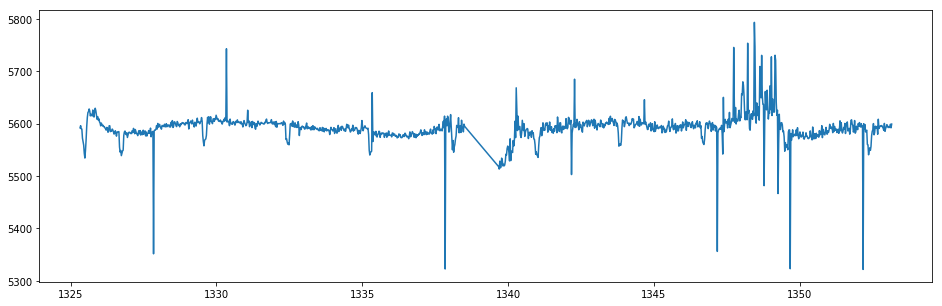

2017.6319160939734


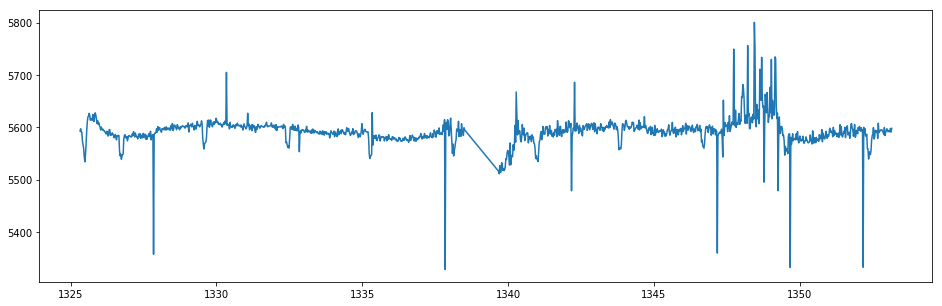

1959.7572535296094


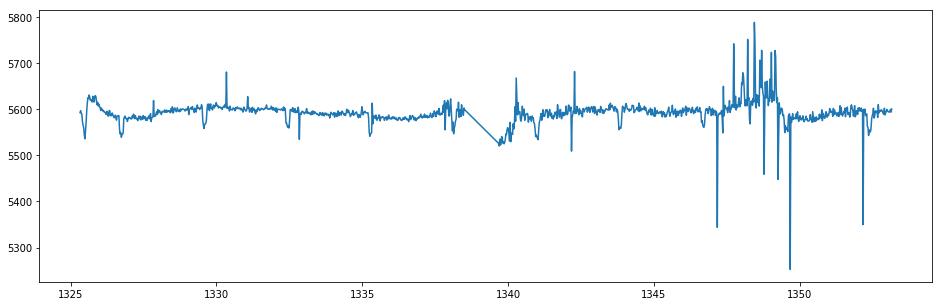

1891.1657755176893


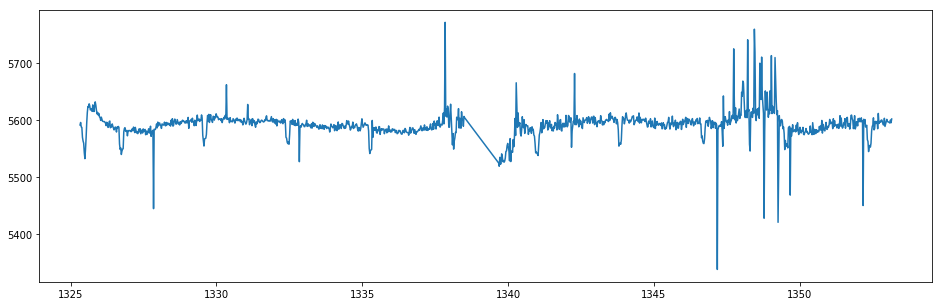

1853.8623306239135


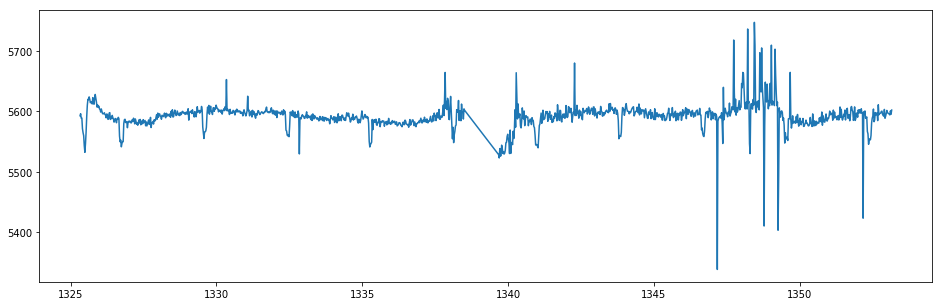

1852.757322420653


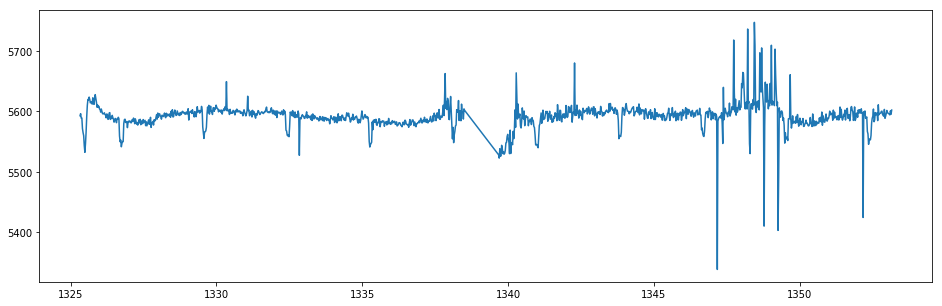

1812.4077264695657


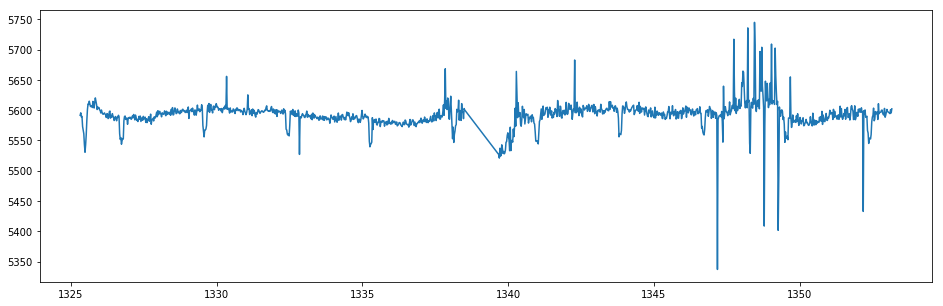

1807.1197780237499


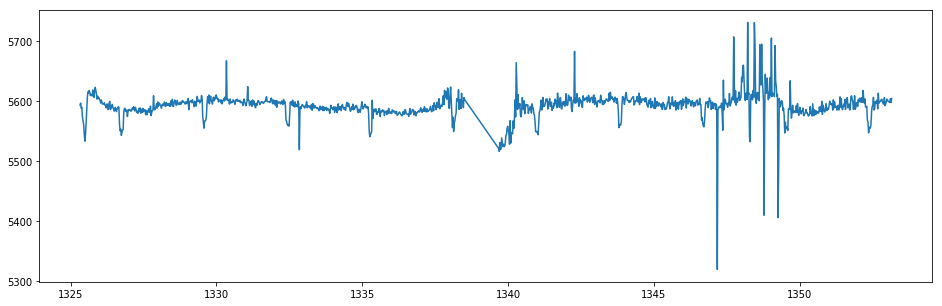

1814.180322686585


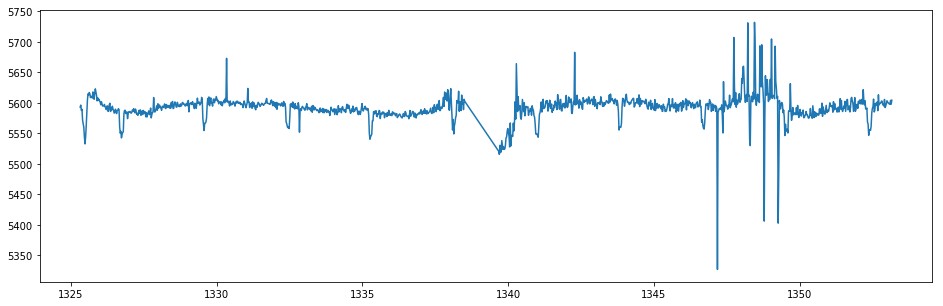

1718.3098425321236


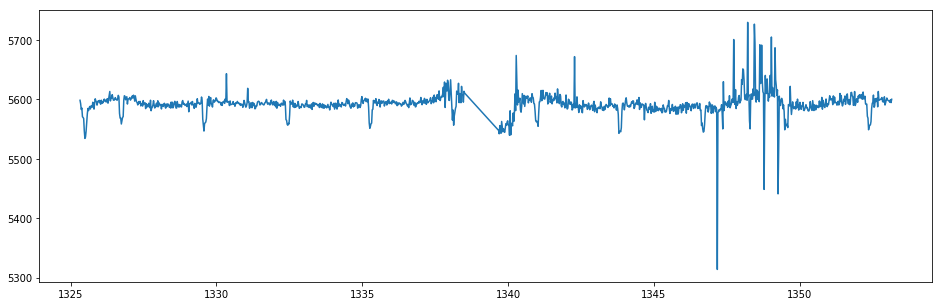

1728.6871437457346


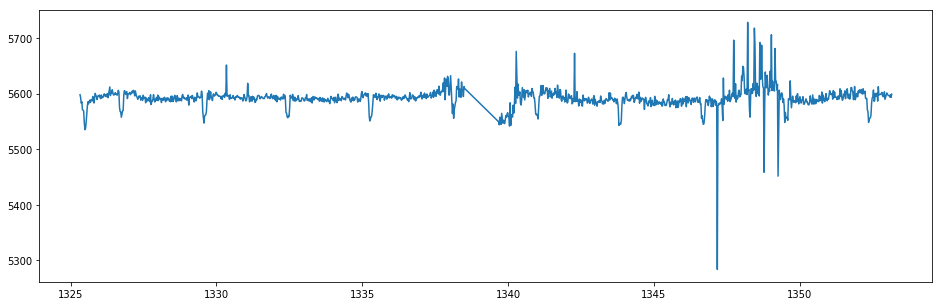

1673.700449697412


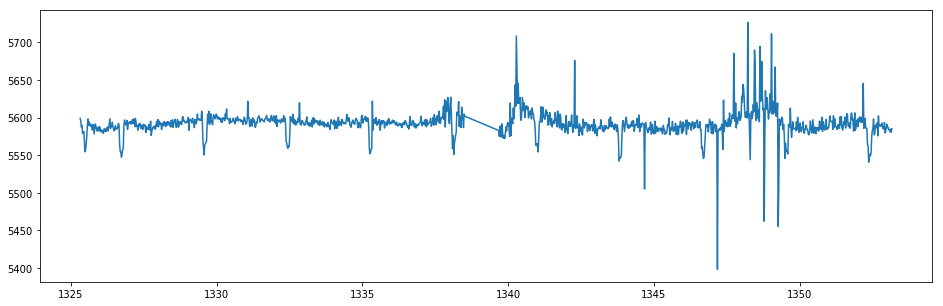

1670.0354706005178


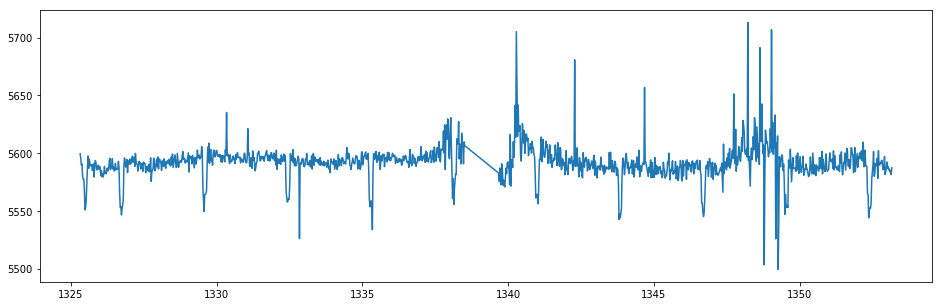

In [38]:
%matplotlib inline
#plt.plot(data.time[q][0:500], flat_lc.flux, 'k')
#plt.plot(data.time[q][0:500], flat_lc2.flux, 'r')
plt.figure(figsize=(16,5))
flat_weights = science(data.corr_flux/np.nanmedian(data.corr_flux))

for nmodes in range(16):
    plt.figure(figsize=(16,5))
    lc_obj = LC(time=data.time, flux=(data.corr_flux - np.dot(A[:,0:nmodes], science(data.corr_flux)[0:nmodes])))
    print(lc_obj.estimate_cdpp(transit_duration=2))
    plt.plot(lc_obj.time, lc_obj.flux)
#plt.ylim(0.98, 1.02)
    plt.show()
    plt.close()

<IPython.core.display.Javascript object>


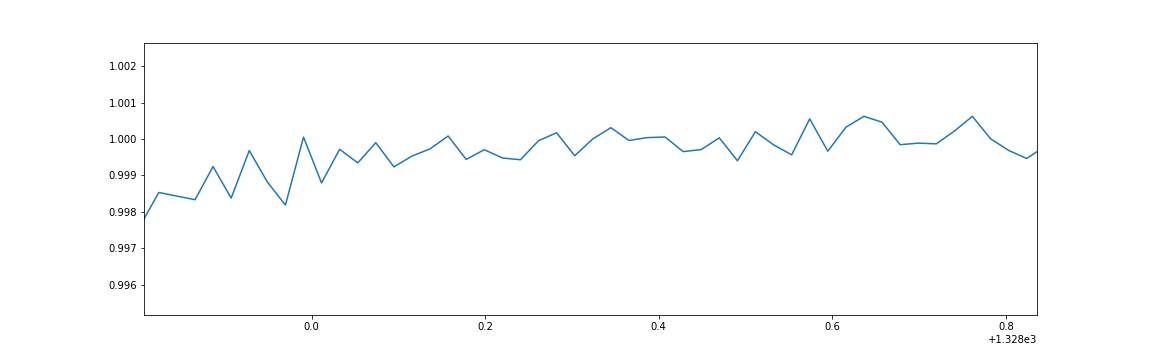

In [94]:
%matplotlib notebook
plt.figure(figsize=(16,5))
plt.plot(data.time[q], flat_lc.flux[q]/np.nanmedian(flat_lc.flux))
plt.ylim(0.96, 1.03)
plt.show()

In [97]:
np.std(flat_lc.flux[q][0:600])/np.sqrt(2)*1e6

1765.5361014647056